# Лабораторная работа 4

В условиях VI.9.29 решить задачу экстраполяции населения страны методами: 

1. Классическая полиномиальная интерполяция по Ньютону
2. Сплайн-интерполяция
3. Метод наименьших квадратов

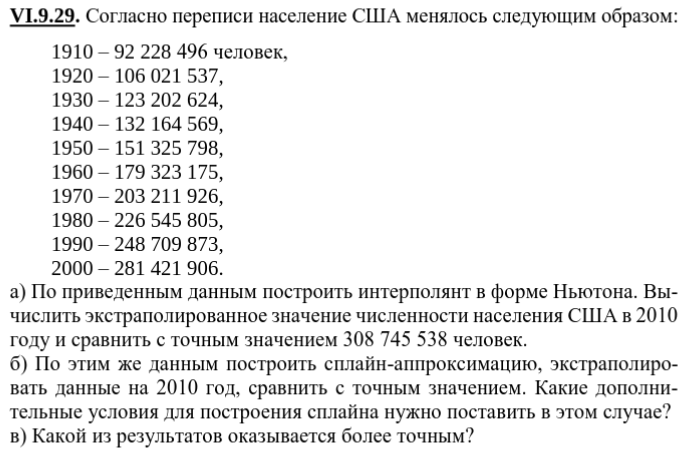

In [ ]:
import numpy as np               
import matplotlib.pyplot as plt   
import pandas as pd

data = {
    "Year": [1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010],
    "Population": [
        92228496, 106021537, 123202624, 132164569, 
        151325798, 179323175, 203211926, 226545805, 
        248709873, 281421906, 308745538
    ]
}

df = pd.DataFrame(data)
print(df)

    Year  Population
0   1910    92228496
1   1920   106021537
2   1930   123202624
3   1940   132164569
4   1950   151325798
5   1960   179323175
6   1970   203211926
7   1980   226545805
8   1990   248709873
9   2000   281421906
10  2010   308745538


## 1. Классическая полиномиальная интерполяция по Ньютону

In [44]:
def Newton(interp_points, func_vals):
    n = len(interp_points)
    divided_diffs = np.zeros((n, n))
    divided_diffs[:, 0] = func_vals

    for j in range(1, n):
        for i in range(n - j):
            numerator = divided_diffs[i + 1, j - 1] - divided_diffs[i, j - 1]
            denom = interp_points[i + j] - interp_points[i]
            divided_diffs[i, j] = numerator / denom

    def interpolating_function(x):
        result = divided_diffs[0, 0]
        for j in range(1, n):
            term = divided_diffs[0, j]
            for k in range(j):
                term *= (x - interp_points[k])
            result += term
        return result

    return interpolating_function

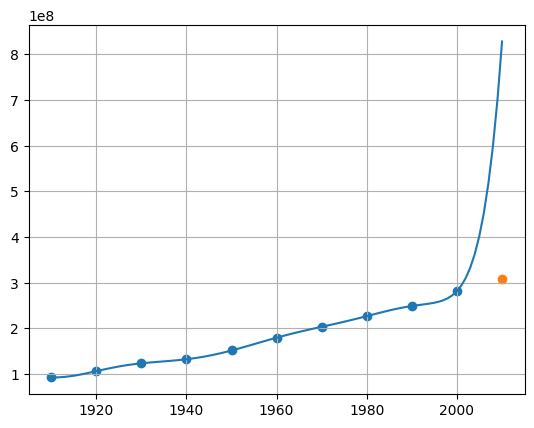

In [43]:
equ = Newton(np.copy(data['Year'][:10]), np.copy(data['Population'][:10]))
n_dots = 100
x = np.linspace(data['Year'][0], data['Year'][10], n_dots)
y = np.array([equ(x[i]) for i in range(n_dots)])

plt.scatter(data['Year'][:10], data['Population'][:10])
plt.scatter(data['Year'][10], data['Population'][10])
plt.plot(x, y)
plt.grid()
plt.show()

## 2. Сплайн-интерполяция

In [42]:
def cubic_spline_solver(intervals, slopes):
    num_intervals = len(intervals)
    
    main_diag = 2 * (intervals[:-1] + intervals[1:])
    sub_diag = intervals[1:-1]
    super_diag = intervals[1:-1]
    rhs = 6 * (slopes[1:] - slopes[:-1])

    main_diag = np.hstack([1, main_diag, 1])
    rhs = np.hstack([0, rhs, 0])
    sub_diag = np.hstack([0, intervals[:-1]])
    super_diag = np.hstack([intervals[:-1], 0])

    A = np.diag(main_diag) + np.diag(sub_diag, k=-1) + np.diag(super_diag, k=1)
    
    return np.linalg.solve(A, rhs)

def cubic_spline_function(x_coords, y_coords):
    num_points = len(x_coords) - 1
    deltas = np.diff(x_coords)
    slopes = np.diff(y_coords) / deltas
    spline_moments = cubic_spline_solver(deltas, slopes)

    def polynomial(x_value):
        interval_idx = np.searchsorted(x_coords, x_value)
        interval_idx = np.clip(interval_idx, 1, num_points)
        
        h = deltas[interval_idx - 1]
        m1 = spline_moments[interval_idx - 1]
        m2 = spline_moments[interval_idx]
        
        y1 = y_coords[interval_idx - 1]
        y2 = y_coords[interval_idx]
        
        part1 = m1 * (x_coords[interval_idx] - x_value)**3 / (6 * h)
        part2 = m2 * (x_value - x_coords[interval_idx - 1])**3 / (6 * h)
        
        part3 = (y1 - m1 * h**2 / 6) * (x_coords[interval_idx] - x_value) / h
        part4 = (y2 - m2 * h**2 / 6) * (x_value - x_coords[interval_idx - 1]) / h
        
        return part1 + part2 + part3 + part4

    return polynomial

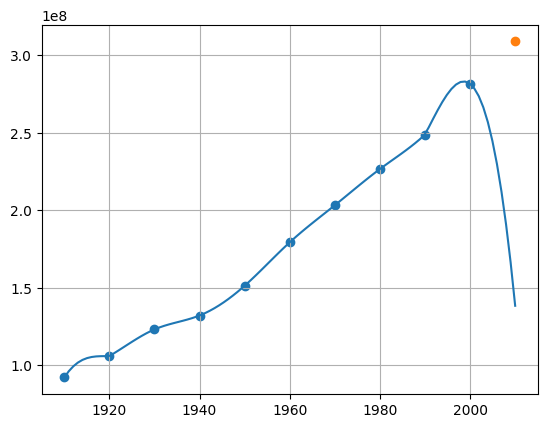

In [41]:
equ = cubic_spline_function(np.copy(data['Year'][:10]), np.copy(data['Population'][:10]))
x = np.linspace(data['Year'][0], data['Year'][10], n_dots)
y = np.array([equ(x[i]) for i in range(n_dots)])

plt.scatter(data['Year'][:10], data['Population'][:10])
plt.scatter(data['Year'][10], data['Population'][10])
plt.plot(x, y)
plt.grid()
plt.show()

## 3. Метод наименьших квадратов

In [40]:
def least_squares_fit(data_x, data_y, basis_funcs):
    basis_matrix = np.array([[basis(x_val) for x_val in data_x] for basis in basis_funcs])

    projections = np.dot(basis_matrix, data_y)
    gram_matrix = np.dot(basis_matrix, basis_matrix.T)

    coefficients = np.linalg.solve(gram_matrix, projections)

    def fitted_function(query_x):
        return np.array([
            np.sum(coeff * basis(q) for coeff, basis in zip(coefficients, basis_funcs))
            for q in np.atleast_1d(query_x)
        ])

    return fitted_function

basis_funcs = np.array([
    lambda x: 1,
    lambda x: x,
    lambda x: x**2,
    lambda x: x**3
])

/tmp/ipykernel_639142/407721231.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(coeff * basis(q) for coeff, basis in zip(coefficients, basis_funcs))


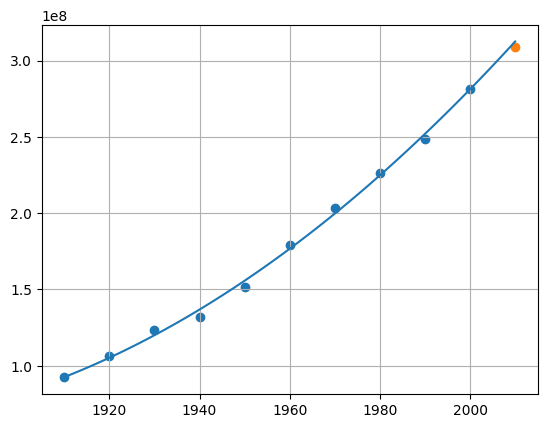

In [39]:
equ = least_squares_fit(np.copy(data['Year'][:10]), np.copy(data['Population'][:10]), basis_funcs)
x = np.linspace(data['Year'][0], data['Year'][10], n_dots)
y = np.array([equ(x[i]) for i in range(n_dots)])

plt.scatter(data['Year'][:10], data['Population'][:10])
plt.scatter(data['Year'][10], data['Population'][10])
plt.plot(x, y)
plt.grid()
plt.show()